In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time


In [9]:
N_POINTS = 1000
BATCH_SIZE = 64
EPOCHS = 400
LR = 0.01
MARGIN = 2.0  # How far apart we want the clusters to be


In [3]:
torch.manual_seed(42)
X = torch.randn(N_POINTS, 2)  # Normal distribution centered at 0,0

# Assign labels: 
# Let's say points with x < 0 are class 0, x > 0 are class 1.
# But we add some noise so they overlap heavily at the center.
labels = (X[:,0] + torch.randn(N_POINTS) * 0.5> 0).float()


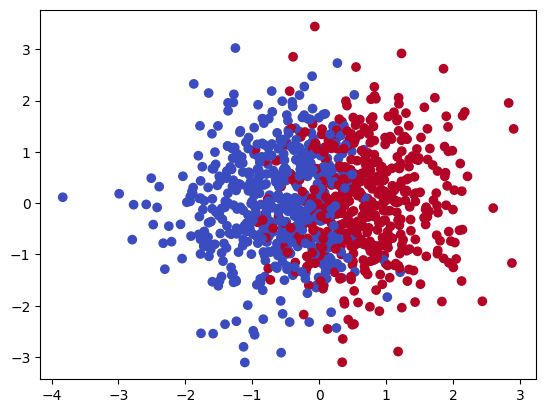

In [4]:
# plot the poits

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="coolwarm")
plt.show()

In [5]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, X, labels):
        self.X = X
        self.labels = labels
        
    def __getitem__(self, index):
        # 1. Pick first point
        x1 = self.X[index]
        l1 = self.labels[index]
        
        # 2. Pick second point
        # We want 50% Same Class, 50% Diff Class
        should_match = torch.rand(1).item() > 0.5
        
        if should_match:
            # Find indices of same class
            indices = (self.labels == l1).nonzero(as_tuple=True)[0]
            label_sim = 0.0 # 0 means "similar" in our loss formula
        else:
            # Find indices of different class
            indices = (self.labels != l1).nonzero(as_tuple=True)[0]
            label_sim = 1.0 # 1 means "dissimilar"
            
        idx2 = indices[torch.randint(len(indices), (1,)).item()]
        x2 = self.X[idx2]
        
        return x1, x2, torch.tensor(label_sim, dtype=torch.float32)

    def __len__(self):
        return len(self.X)


In [6]:
class SimpleProjector(nn.Module):
    def __init__(self):
        super().__init__()
        # A simple MLP: 2D Input -> Hidden -> 2D Output
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2) # Output 2D so we can plot it easily
        )
        
    def forward(self, x):
        return self.net(x)


In [10]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
        
    def forward(self, out1, out2, label):
        # Euclidean distance
        dist = F.pairwise_distance(out1, out2)
        
        # Loss:
        # If similar (label=0): minimize distance^2
        # If diff    (label=1): minimize max(0, margin - distance)^2
        loss = torch.mean((1-label) * torch.pow(dist, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))
        return loss


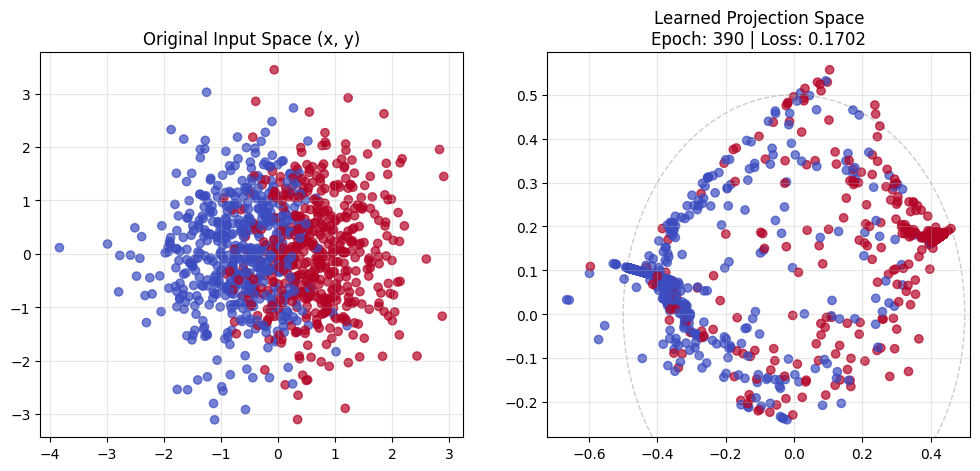

In [8]:
dataset = PairDataset(X, labels)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = SimpleProjector()
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = ContrastiveLoss(margin=MARGIN)

# Setup the plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot initial input state
axes[0].scatter(X[:,0], X[:,1], c=labels, cmap='coolwarm', alpha=0.7)
axes[0].set_title("Original Input Space (x, y)")
axes[0].grid(True, alpha=0.3)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for x1, x2, pair_label in loader:
        optimizer.zero_grad()
        out1 = model(x1)
        out2 = model(x2)
        loss = criterion(out1, out2, pair_label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # --- Animation Step ---
    if epoch % 10 == 0: # Update plot
        model.eval()
        with torch.no_grad():
            # Get projection of ALL points
            projected = model(X)
            
        # Clear the "Learned Projection" axis only
        axes[1].cla()
        
        # Plot the learned embeddings
        axes[1].scatter(projected[:,0], projected[:,1], c=labels, cmap='coolwarm', alpha=0.7)
        axes[1].set_title(f"Learned Projection Space\nEpoch: {epoch} | Loss: {epoch_loss/len(loader):.4f}")
        axes[1].grid(True, alpha=0.3)
        
        # Draw a circle to visualize the margin (conceptually)
        circle = plt.Circle((0, 0), MARGIN/2, color='black', fill=False, linestyle='--', alpha=0.2)
        axes[1].add_artist(circle)

        # Update display
        display(fig)
        clear_output(wait=True)
        # plt.pause(1) # Optional, helps if not running in notebook
        
        



In [11]:
import sklearn
from sklearn.cluster import KMeans

In [12]:
kmeans_iter = 500

In [13]:
k1 = KMeans(n_clusters=2, max_iter=kmeans_iter)
k1.fit(X.numpy())

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",2
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",500
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",None
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


Text(0.5, 1.0, 'Predicted by KMeans on Original Data')

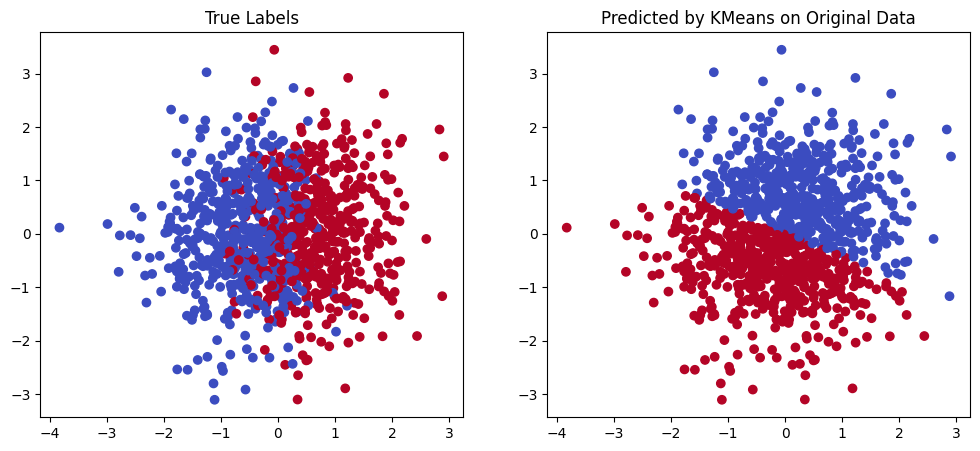

In [14]:
# plot misclassified points by KMeans
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(X[:, 0], X[:, 1], c = labels , cmap="coolwarm")
ax[0].set_title("True Labels")
ax[1].scatter(X[:, 0], X[:, 1], c = k1.labels_ , cmap="coolwarm")
ax[1].set_title("Predicted by KMeans on Original Data")

In [15]:
k2 = KMeans(n_clusters=2, max_iter=kmeans_iter)
projected = model(X).detach().numpy()
k2.fit(projected)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",2
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",500
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",None
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


Text(0.5, 1.0, 'Predicted by KMeans on Projected Data')

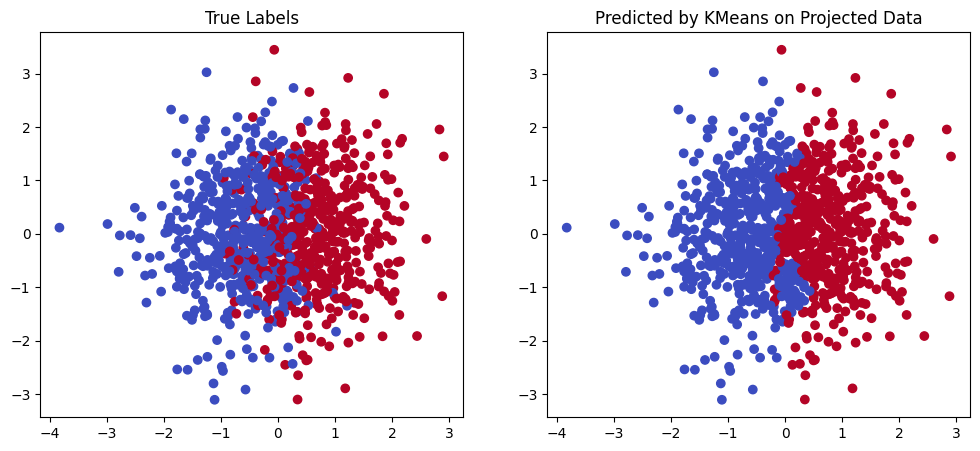

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(X[:, 0], X[:, 1], c = labels , cmap="coolwarm")
ax[0].set_title("True Labels")
ax[1].scatter(X[:, 0], X[:, 1], c = k2.labels_ , cmap="coolwarm")
ax[1].set_title("Predicted by KMeans on Projected Data")

In [17]:
k1_error = k1.labels_ != labels.numpy()
k2_error = k2.labels_ != labels.numpy()

print(f"KMeans on Original Data Error Rate: {k1_error.sum()}/{N_POINTS} = {k1_error.sum()/N_POINTS:.2%}")
print(f"KMeans on Learned Projection Error Rate: {k2_error.sum()}/{N_POINTS} = {k2_error.sum()/N_POINTS:.2%}")


KMeans on Original Data Error Rate: 610/1000 = 61.00%
KMeans on Learned Projection Error Rate: 135/1000 = 13.50%


In [18]:
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 1),  # Output logits for 2 classes
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.net(x)
    

In [19]:
EPOCHS_CLS = 50
lr_CLS = 0.1
criterion_cls = nn.BCELoss()

In [20]:
# train the classifier on the learned projection
classifier = SimpleClassifier()
optimizer_cls = optim.Adam(classifier.parameters(), lr=lr_CLS)
criterion_cls = nn.BCELoss()

model.eval()
with torch.no_grad():
    projected = model(X)

for epoch in range(EPOCHS_CLS):
    classifier.train()
    optimizer_cls.zero_grad()
    
    outputs = classifier(projected)
    loss = criterion_cls(outputs.squeeze(), labels.float())
    loss.backward()
    optimizer_cls.step()
# Evaluate classifier
classifier.eval()
with torch.no_grad():
    outputs = classifier(projected)
    # _, predicted = torch.max(outputs, 1)
    accuracy = ((outputs.squeeze() > 0.5) == labels.float()).float().mean().item()
print(f"Classifier Accuracy on Learned Projection: {accuracy*100:.2f}%")


Classifier Accuracy on Learned Projection: 86.50%


In [21]:
classifier = SimpleClassifier()
optimizer_cls = optim.Adam(classifier.parameters(), lr=lr_CLS)
criterion_cls = nn.BCELoss()

for epoch in range(EPOCHS_CLS):
    classifier.train()
    optimizer_cls.zero_grad()
    
    outputs = classifier(X)
    loss = criterion_cls(outputs.squeeze(), labels.float())
    loss.backward()
    optimizer_cls.step()
# Evaluate classifier
classifier.eval()
with torch.no_grad():
    outputs = classifier(X)
    #_, predicted = torch.max(outputs, 1)
    accuracy = ((outputs.squeeze() > 0.5) == labels.float()).float().mean().item()
print(f"Classifier Accuracy on Original Data: {accuracy*100:.2f}%")


Classifier Accuracy on Original Data: 83.50%
